In [23]:
# Using google Colab
# Install necessary packages
!pip install pyspark medmnist tensorflow findspark scikit-learn matplotlib

In [24]:
# Initialize findspark
import findspark
findspark.init()

In [25]:
# Import necessary libraries
from pyspark.sql import SparkSession
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from medmnist import INFO, ChestMNIST
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize

In [26]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Final Project Team 19") \
    .getOrCreate()

In [27]:
# Dataset Configuration
data_flag = 'chestmnist'
info = INFO[data_flag]

In [28]:
# Load the dataset using MedMNIST library
train_dataset = ChestMNIST(split='train', download=True)


Using downloaded and verified file: /root/.medmnist/chestmnist.npz


In [29]:
X_train = train_dataset.imgs


In [30]:
import numpy as np
from sklearn.utils import resample

def create_binary_dataset(X, y, num_samples=25000, random_state=42):

    # Ensure reproducibility
    np.random.seed(random_state)

    # Sum labels per sample to identify samples with label zero
    label_sums = y.sum(axis=1)

    # Samples with label zero (all-zero labels)
    idx_label_zero = np.where(label_sums == 0)[0]
    X_label_zero = X[idx_label_zero]
    y_label_zero = y[idx_label_zero]

    # Samples with other labels (nonzero label sums)
    idx_other_labels = np.where(label_sums > 0)[0]
    X_other_labels = X[idx_other_labels]
    y_other_labels = y[idx_other_labels]

    # Determine the frequency of each label in nonzero data
    label_frequencies = np.sum(y[idx_other_labels], axis=0)
    label_order = np.argsort(label_frequencies)[::-1]

    # Collect samples for label 1 based on frequency
    selected_indices = []
    for label_idx in label_order:
        label_specific_indices = idx_other_labels[np.where(y[idx_other_labels, label_idx] == 1)[0]]
        if len(selected_indices) + len(label_specific_indices) <= num_samples:
            selected_indices.extend(label_specific_indices)
        else:
            # Add only the remaining required samples
            remaining_samples = num_samples - len(selected_indices)
            selected_indices.extend(label_specific_indices[:remaining_samples])
            break

    # Subset the most frequent nonzero labels to meet the quota for label 1
    selected_indices = np.array(selected_indices)
    X_label_one = X[selected_indices]
    y_label_one = y[selected_indices]

    # Randomly sample class 0 data to match the target size
    X_label_zero_selected, y_label_zero_selected = resample(
        X_label_zero, y_label_zero,
        replace=False,
        n_samples=num_samples,
        random_state=random_state
    )

    # Assign binary labels
    y_label_zero_binary = np.zeros(len(y_label_zero_selected), dtype=int)
    y_label_one_binary = np.ones(len(y_label_one), dtype=int)

    # Combine datasets
    X_binary = np.concatenate((X_label_zero_selected, X_label_one), axis=0)
    y_binary = np.concatenate((y_label_zero_binary, y_label_one_binary), axis=0)

    # Shuffle the combined dataset
    indices = np.arange(len(y_binary))
    np.random.shuffle(indices)
    X_binary = X_binary[indices]
    y_binary = y_binary[indices]

    return X_binary, y_binary


In [31]:
# Create the binary dataset
X_train_binary, y_train_binary = create_binary_dataset(X_train, train_dataset.labels, num_samples=25000, random_state=42)

# Verify the sizes
print(f"Number of samples: {len(X_train_binary)}")
print(f"Number of class 0 samples: {np.sum(y_train_binary == 0)}")
print(f"Number of class 1 samples: {np.sum(y_train_binary == 1)}")


Number of samples: 50000
Number of class 0 samples: 25000
Number of class 1 samples: 25000


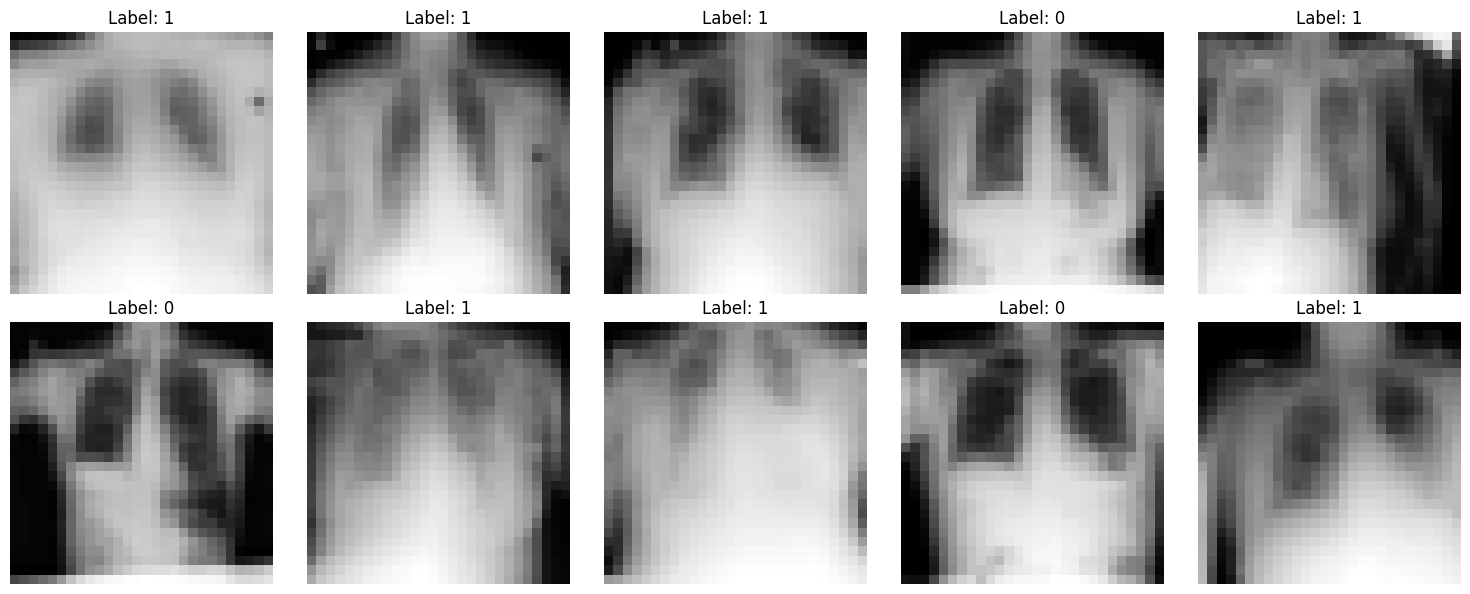

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def show_samples(X, y, num_samples=10):

    # Random samples
    indices = np.random.choice(len(X), num_samples, replace=False)


    rows = num_samples // 5 + (num_samples % 5 != 0)
    cols = min(5, num_samples)


    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.ravel() if rows > 1 else [axes]

    for idx, ax in zip(indices, axes):
        img = X[idx].squeeze()
        label = y[idx]
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Label: {label}', fontsize=12)
        ax.axis('off')


    for ax in axes[len(indices):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_samples(X_train_binary, y_train_binary, num_samples=10)


In [33]:
from sklearn.model_selection import train_test_split

def split_data(X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=42):

    assert train_size + val_size + test_size == 1, "Proportions must sum to 1."

    # First split: Train + Val and Test
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(val_size + test_size), random_state=random_state
    )

    # Second split: Validation and Test
    val_test_ratio = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(1 - val_test_ratio), random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

# Split the dataset
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_train_binary, y_train_binary)

# Print the sizes of each split
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")


Training set: 40000 samples
Validation set: 5000 samples
Test set: 5000 samples


In [34]:
# # Apply binary conversion to labels
# y_train = convert2Binary(train_dataset.labels)
# y_val = convert2Binary(val_dataset.labels)
# y_test = convert2Binary(test_dataset.labels)

In [35]:
# Normalize pixel values
X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0

# Add channel dimension for CNN
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [36]:
print(f"Dataset Sizes:")
print(f"Training Set: {len(X_train)}")
print(f"Validation Set: {len(X_val)}")
print(f"Test Set: {len(X_test)}")

Dataset Sizes:
Training Set: 40000
Validation Set: 5000
Test Set: 5000


In [37]:
# Rebalance the Dataset (Over-sampling minority class)
def rebalance_data(X, y):
    X_negative = X[y == 0]
    y_negative = y[y == 0]
    X_positive = X[y == 1]
    y_positive = y[y == 1]

    # Under-sample majority class
    if len(y_negative) > len(y_positive):
        X_majority = X_negative
        y_majority = y_negative
        X_minority = X_positive
        y_minority = y_positive
    else:
        X_majority = X_positive
        y_majority = y_positive
        X_minority = X_negative
        y_minority = y_negative

    X_majority_undersampled, y_majority_undersampled = resample(
        X_majority, y_majority,
        replace=False,
        n_samples=len(y_minority),
        random_state=42
    )

    # Combine the under-sampled majority and minority samples
    X_balanced = np.vstack((X_majority_undersampled, X_minority))
    y_balanced = np.hstack((y_majority_undersampled, y_minority))

    # Shuffle the dataset
    indices = np.arange(len(y_balanced))
    np.random.seed(42)
    np.random.shuffle(indices)

    return X_balanced[indices], y_balanced[indices]


In [38]:
# Rebalance training data
X_train_balanced, y_train_balanced = rebalance_data(X_train, y_train)


In [39]:
print(f"Dataset Sizes:")
print(f"Training Set: {len(X_train)}")
print(f"Validation Set: {len(X_val)}")
print(f"Test Set: {len(X_test)}")

Dataset Sizes:
Training Set: 40000
Validation Set: 5000
Test Set: 5000


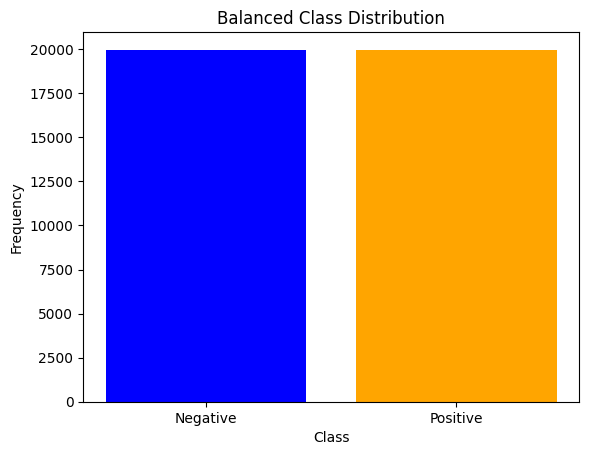

In [40]:
# Visualize Class Distribution
def plot_class_distribution(labels, title="Class Distribution"):
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts, color=['blue', 'orange'])
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.xticks(unique, ['Negative', 'Positive'])
    plt.show()

plot_class_distribution(y_train_balanced, title="Balanced Class Distribution")

In [41]:
from tensorflow.keras.regularizers import l2

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.02)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 13, 13, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 5, 5, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1, 1, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,641 (158.75 KB)

 Trainable params: 40,417 (157.88 KB)

 Non-trainable params: 224 (896.00 B)

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Train with augmented data
history = model.fit(datagen.flow(X_train, y_train, batch_size=64), validation_data=(X_val, y_val), epochs=100)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - accuracy: 0.6331 - loss: 1.3175 - precision_1: 0.6339 - recall_1: 0.6299 - val_accuracy: 0.5910 - val_loss: 0.6665 - val_precision_1: 0.5542 - val_recall_1: 0.8972
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6739 - loss: 0.6280 - precision_1: 0.6786 - recall_1: 0.6618 - val_accuracy: 0.6280 - val_loss: 0.6527 - val_precision_1: 0.7356 - val_recall_1: 0.3903
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6796 - loss: 0.6171 - precision_1: 0.6914 - recall_1: 0.6576 - val_accuracy: 0.6480 - val_loss: 0.6391 - val_precision_1: 0.6190 - val_recall_1: 0.7552
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.6822 - loss: 0.6164 - precision_1: 0.6924 - recall_1: 0.6671 - val_accuracy: 0.6708 - val_loss: 0.6295 - val_precision_1: 0.6440 - val_recall_1: 0.7520
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6856 - loss: 0.6134 - precision_1: 0.6997 - recall_1: 0.657

In [44]:
# Train the Model using Keras
history_1 = model.fit(X_train_balanced, y_train_balanced, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7170 - loss: 0.5758 - precision_1: 0.7248 - recall_1: 0.6926 - val_accuracy: 0.7074 - val_loss: 0.5857 - val_precision_1: 0.7221 - val_recall_1: 0.6665
Epoch 2/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7204 - loss: 0.5703 - precision_1: 0.7311 - recall_1: 0.6921 - val_accuracy: 0.7120 - val_loss: 0.5843 - val_precision_1: 0.7222 - val_recall_1: 0.6815
Epoch 3/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7223 - loss: 0.5701 - precision_1: 0.7360 - recall_1: 0.7005 - val_accuracy: 0.6854 - val_loss: 0.5992 - val_precision_1: 0.7872 - val_recall_1: 0.5012
Epoch 4/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7297 - loss: 0.5621 - precision_1: 0.7434 - recall_1: 0.7038 - val_accuracy: 0.7138 - val_loss: 0.5863 - val_precision_1: 0.7565 - val_recall_1: 0.6238
Epoch 5/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7286 - loss: 0.5617 - precision_1: 0.7402 - r

In [45]:
# Evaluate the Model
print(f"Test Accuracy: {model.evaluate(X_test, y_test, verbose=0)}")

Test Accuracy: [0.7778446078300476, 0.6800000071525574, 0.6813008189201355, 0.6725521683692932]


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


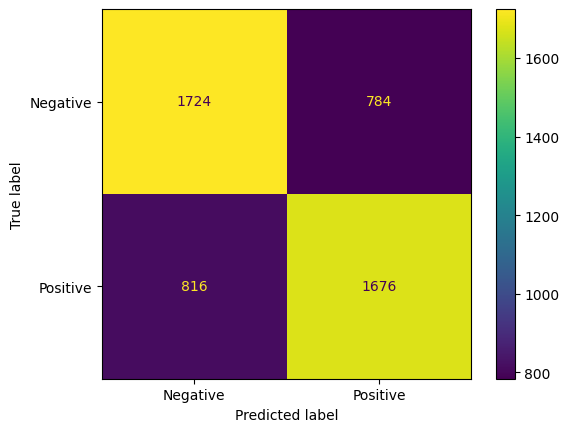

In [46]:
# Confusion Matrix
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary, display_labels=['Negative', 'Positive'])
plt.show()

In [47]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary, target_names=['Negative', 'Positive']))

Classification Report:
              precision    recall  f1-score   support

    Negative       0.68      0.69      0.68      2508
    Positive       0.68      0.67      0.68      2492

    accuracy                           0.68      5000
   macro avg       0.68      0.68      0.68      5000
weighted avg       0.68      0.68      0.68      5000



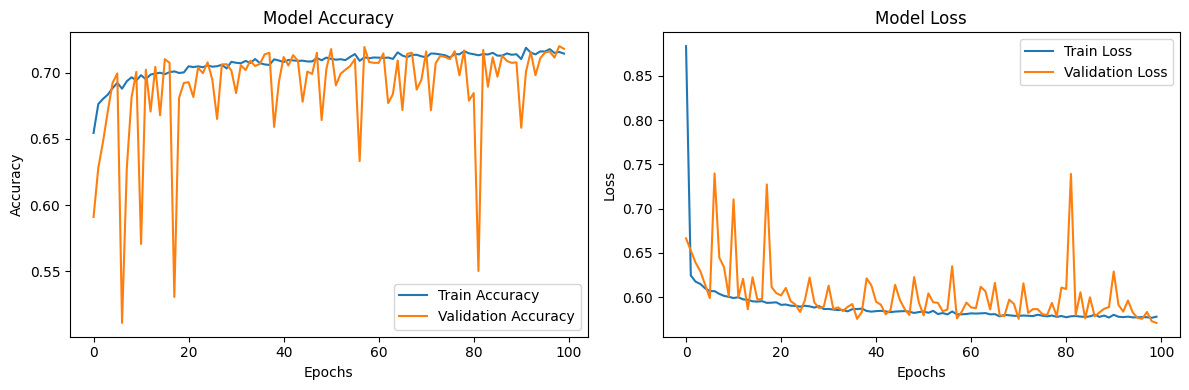

In [48]:
# Training History Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [1]:
# Training History Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined